Name : Hazem Bin Ryaz Patel (2200550)
Class : DAAA/2B/07 


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import visualkeras
import keras
import numpy as np
import seaborn as sns
from keras.layers import (
    AveragePooling2D,
    ZeroPadding2D,
    BatchNormalization,
    Activation,
    MaxPool2D,
    Add,
)
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.utils.class_weight import compute_class_weight

In [2]:
seed_r = 42
np.random.seed(seed_r)

## EDA

### Loading in data

In [3]:
data_dir = "./Dataset for CA1 part A"
# image_count = len(list(data_dir.glob('*/*.jpg')))

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/train",
    seed=seed_r,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/validation",
    seed=seed_r,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/test",
    seed=seed_r,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


### Visualizing the data

In [4]:
class_names = train_ds.class_names
print(len(class_names))

15


In [5]:
x_train = []
y_train = []

for images, labels in train_ds:
    x_train.extend(images.numpy())
    y_train.extend(labels.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)

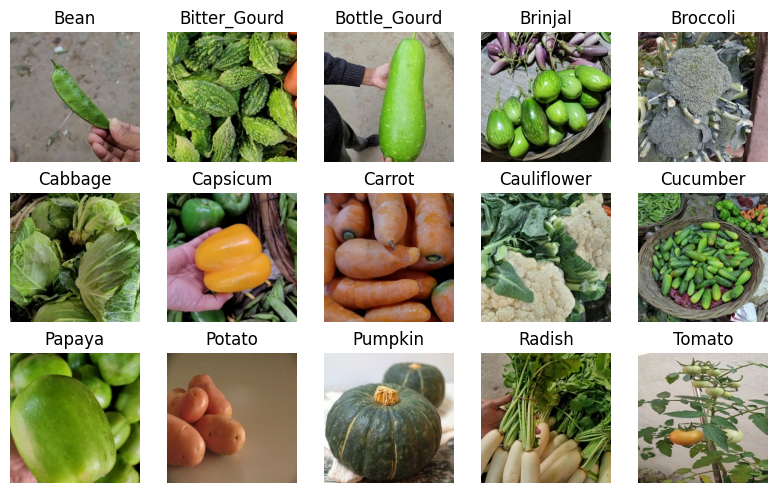

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(8, 5), tight_layout=True)

for label, subplot in enumerate(ax.ravel()):
    subplot.axis("off")
    subplot.imshow(
        x_train[y_train == label][
            np.random.randint(0, len(x_train[y_train == label]))
        ].astype("uint8"),
        cmap="Greys",
    )
    subplot.set_title(class_names[label])

plt.show()

### Checking for mislabelled data

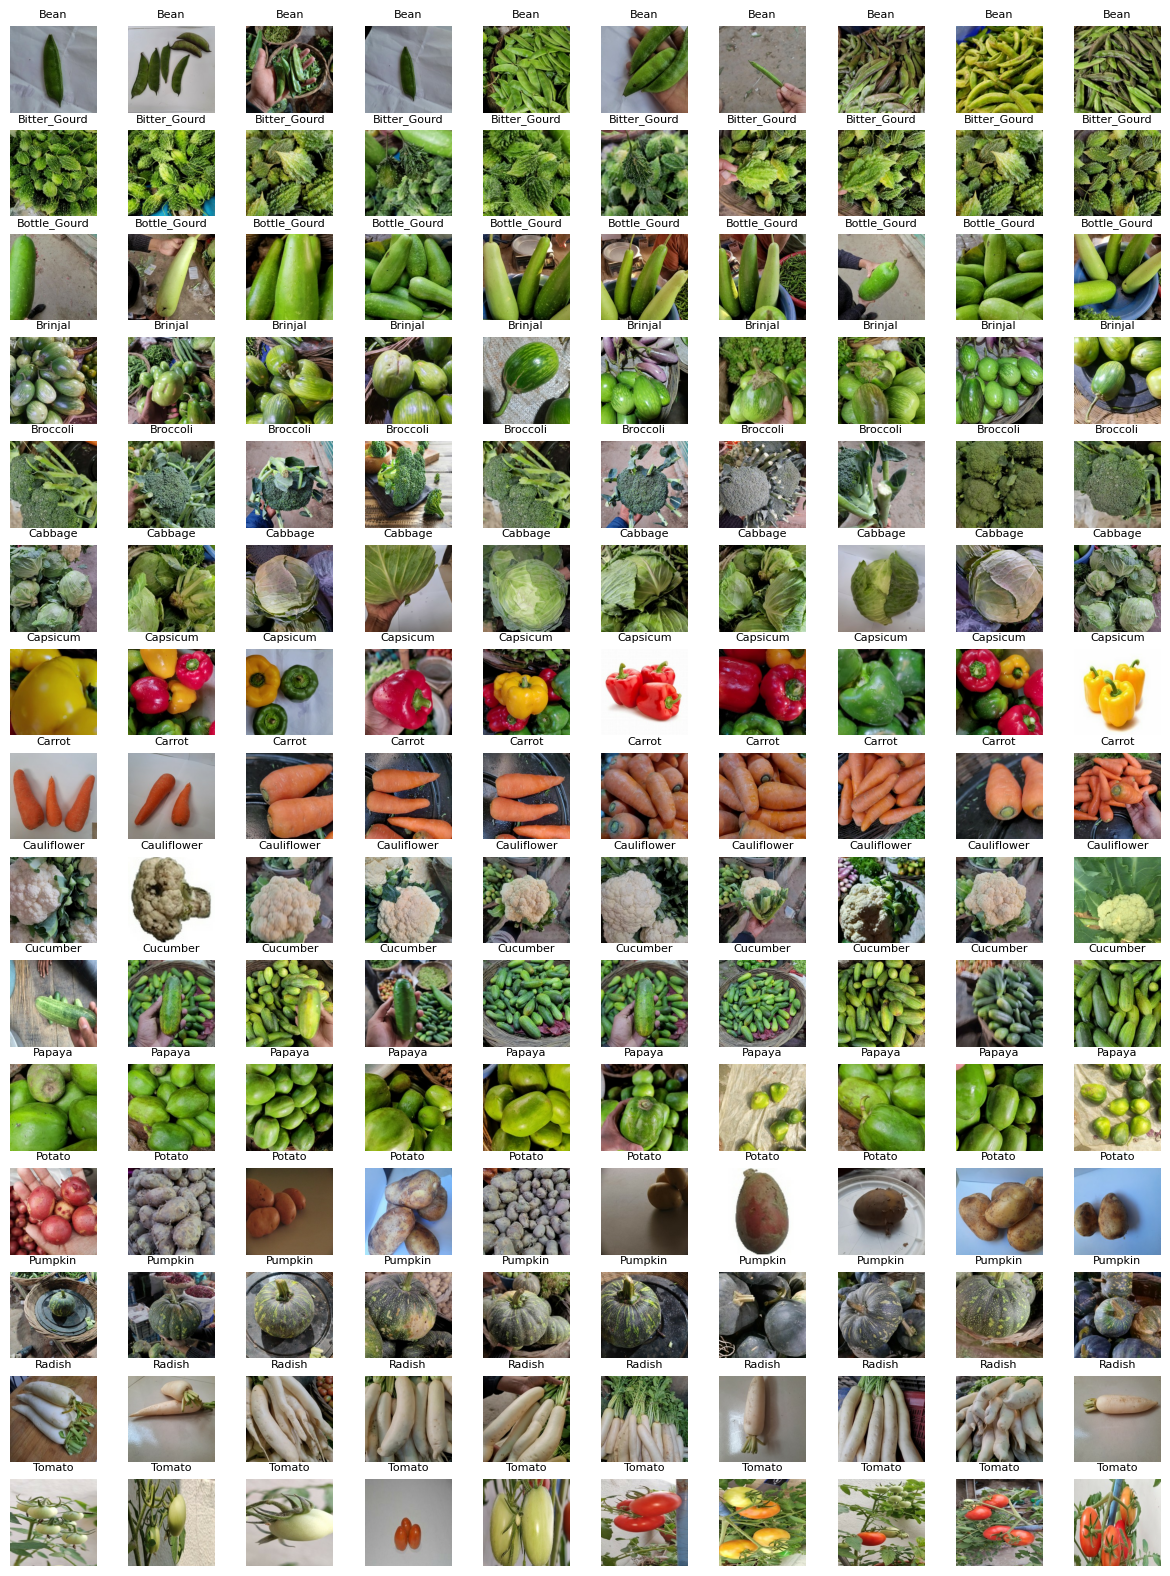

In [7]:
fig, ax = plt.subplots(15, 10, figsize=(15, 20))
for i in range(15):
    images = x_train[np.squeeze(y_train == i)].astype("uint8")
    random_index = np.random.choice(images.shape[0], 15, replace=False)
    images = images[random_index]
    label = class_names[i]
    for j in range(10):
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[j], cmap='Greys')
        subplot.set_title(label, fontsize=8)

plt.show()

Conclusion : There isn't any mislabelling, so we don't need to re-label any of the data

### Image Averaging

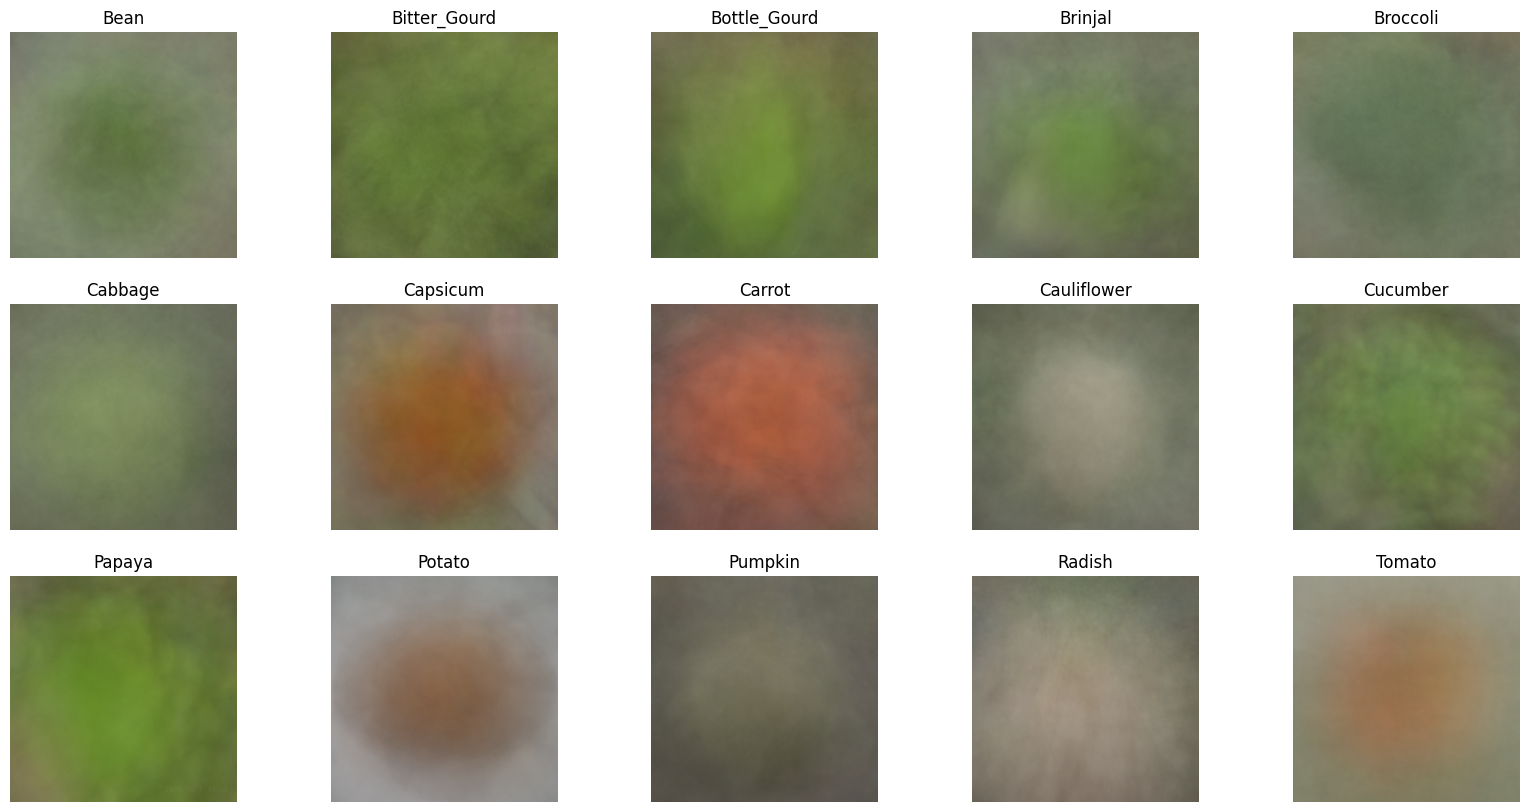

In [8]:
fig, ax = plt.subplots(3, 5, figsize=(20, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(x_train[np.squeeze(y_train == idx)], axis=0) / 255
    subplot.imshow(avg_image, cmap="Greys")
    subplot.set_title(f"{class_names[idx]}")
    subplot.axis("off")

While some exhibit discernible colors, most appear as a ball of vibrant green hues

### Distribution of Classes

Bean: 780
Bitter_Gourd: 720
Bottle_Gourd: 441
Brinjal: 868
Broccoli: 750
Cabbage: 503
Capsicum: 351
Carrot: 256
Cauliflower: 587
Cucumber: 812
Papaya: 566
Potato: 377
Pumpkin: 814
Radish: 248
Tomato: 955


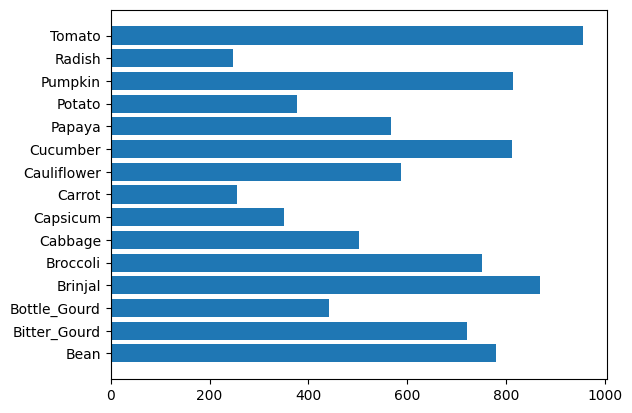

In [9]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

plt.barh(labels, counts, tick_label=class_names)
plt.show()

## Pre-Processing 

### Oversampling with the use of Data Augmentations
One of the things that is important to address is the imbalance of data. I've chosen to augment the data to help with the disparity

In [10]:
train_dict = {tf.Tensor.ref(img): label for img, label in train_ds.unbatch()}

def data_augmentation(data):
    imageArr = []
    for images in data:
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_crop(
            image, size=(224,224,3)
        )
        imageArr.append(tf.reshape(image, (224, 224, 3)))
    return np.array(imageArr)

def augment_undersampled_vegs(img_labels, X_train, y_train):
    undersampled_labels = []
    undersampled_vegs = []
    for veg_type in img_labels:
        # Get all images of a veg type
        veg_images = [img.deref() for img, label in train_dict.items() if label == veg_type]
        veg_labels = [label for img, label in train_dict.items() if label == veg_type]

        if veg_type == img_labels[0]:
            undersampled_vegs = veg_images
            undersampled_labels = veg_labels     
        else : 
            undersampled_vegs = np.concatenate((undersampled_vegs, veg_images), axis=0)
            undersampled_labels = np.concatenate((undersampled_labels, veg_labels), axis=0)

        veg_train_aug = data_augmentation(undersampled_vegs)
    
    print(veg_train_aug.shape)
    print(undersampled_labels.shape)

    X_train = np.concatenate((X_train, veg_train_aug), axis=0)
    y_train = np.concatenate((y_train, undersampled_labels), axis=0)
    return X_train, y_train

# veg_types are the labels of the vegetables which are undersampled
veg_types = [2,5,6,7,10,11,13]

X_train_aug, y_train_aug = augment_undersampled_vegs(veg_types, x_train, y_train)

(2742, 224, 224, 3)
(2742,)


In [11]:
with tf.device('/device:CPU:0'):
    train_ds_rebatch = tf.data.Dataset.from_tensor_slices((X_train_aug, y_train_aug))
    train_ds_rebatch = train_ds_rebatch.shuffle(buffer_size=len(X_train_aug))  # Shuffle the data
    train_ds_rebatch = train_ds_rebatch.batch(32)

In [12]:
def process(ds):
    ds = ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))
    return ds

train_non_aug_ds_128 = process(train_ds)
train_ds_128 = process(train_ds_rebatch)
val_ds_128 = process(val_ds)
test_ds_128 = process(test_ds)

## EDA after pre-processing
How do the images look now

In [13]:
x_train_128 = []
y_train_128 = []

for images, labels in train_ds_128:
    x_train_128.extend(images.numpy())
    y_train_128.extend(labels.numpy())

x_train_128 = np.array(x_train_128)
y_train_128 = np.array(y_train_128)

Bean: 780
Bitter_Gourd: 720
Bottle_Gourd: 882
Brinjal: 868
Broccoli: 750
Cabbage: 1006
Capsicum: 702
Carrot: 512
Cauliflower: 587
Cucumber: 812
Papaya: 1132
Potato: 754
Pumpkin: 814
Radish: 496
Tomato: 955


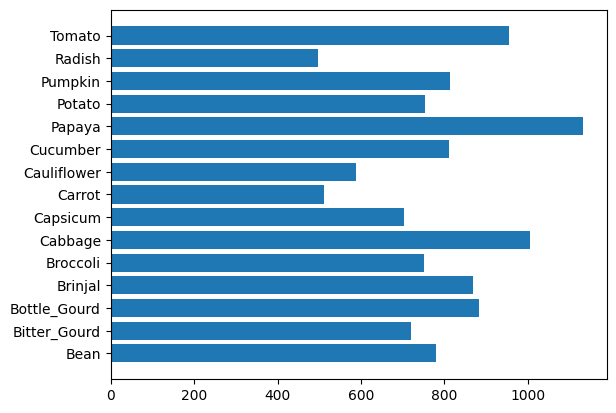

In [14]:
labels, counts = np.unique(y_train_128, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

plt.barh(labels, counts, tick_label=class_names)
plt.show()

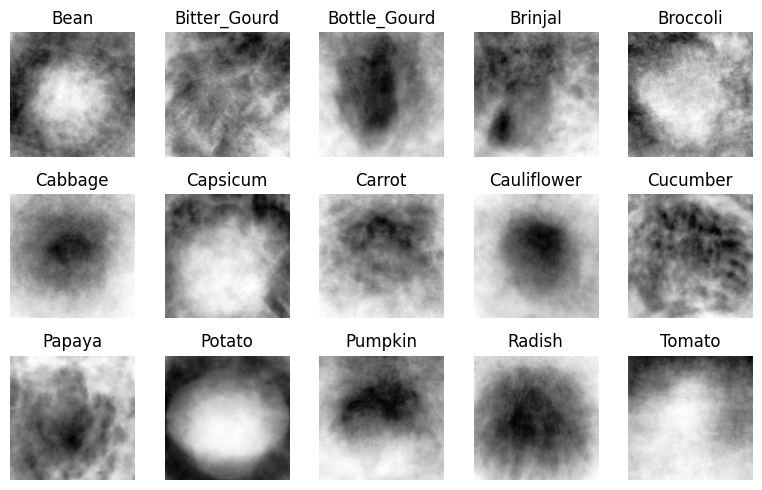

In [15]:
fig, ax = plt.subplots(3, 5, figsize=(8,5), tight_layout=True)

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(x_train_128[np.squeeze(y_train_128 == idx)], axis=0) / 255
    subplot.imshow(avg_image, cmap="Greys")
    subplot.set_title(f"{class_names[idx]}")
    subplot.axis("off")

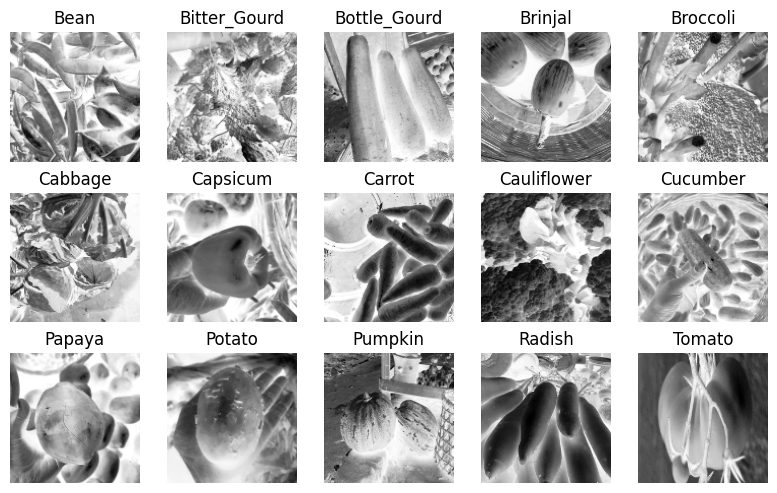

In [16]:
fig, ax = plt.subplots(3, 5, figsize=(8, 5), tight_layout=True)

for label, subplot in enumerate(ax.ravel()):
    subplot.axis("off")
    subplot.imshow(
        x_train_128[y_train_128 == label][
            np.random.randint(0, len(x_train_128[y_train_128 == label]))
        ],
        cmap="Greys",
    )
    subplot.set_title(class_names[label])

plt.show()

## Training for CNN 128
Element of modelling to consider
- With Augmentation or W/out
- Does Class_Weight_Dict help the augmentation or not much difference


### Base Model


In [17]:
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train_128), y = y_train_128)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
def conv2d_block(layer_number):
    layer_number = 5 + layer_number
    conv_filter1 = 2**layer_number
    ks = (7,7) if layer_number == 0 else (5,5) if layer_number == 1 else (3,3)    
    return Sequential(
        [
            Conv2D(conv_filter1, ks, padding="same", activation="relu"),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.2)
        ]
    )

In [ ]:
def base_model_128():  
    model = Sequential()
    for i in range(4):
        model.add(conv2d_block(i))
        if ((i+1) % 2 == 0):
            model.add(MaxPooling2D(2, 2))
            model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(15, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

model_128 = base_model_128()
history_128 = model_128.fit(
    train_ds_128, 
    validation_data=val_ds_128, 
    epochs=30, 
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'), 
    ModelCheckpoint('base_model_128.h5', monitor='val_loss', save_best_only=True, verbose=1)]
)

model_128.evaluate(test_ds_128)
model_128.summary()
plot_model(model_128, show_shapes=True, show_layer_names=True)

Epoch 1/30
368/368 [==============================] - ETA: 0s - loss: 2.0358 - accuracy: 0.4004
Epoch 1: val_loss improved from inf to 3.91330, saving model to base_model_128.h5
368/368 [==============================] - 14s 24ms/step - loss: 2.0358 - accuracy: 0.4004 - val_loss: 3.9133 - val_accuracy: 0.1807
Epoch 2/30
368/368 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.6983
Epoch 2: val_loss improved from 3.91330 to 1.34507, saving model to base_model_128.h5
368/368 [==============================] - 8s 23ms/step - loss: 0.9239 - accuracy: 0.6983 - val_loss: 1.3451 - val_accuracy: 0.6310
Epoch 3/30
366/368 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.8008
Epoch 3: val_loss improved from 1.34507 to 0.84715, saving model to base_model_128.h5
368/368 [==============================] - 8s 23ms/step - loss: 0.5968 - accuracy: 0.8012 - val_loss: 0.8472 - val_accuracy: 0.7650
Epoch 4/30
366/368 [============================>.] - ETA: 0s

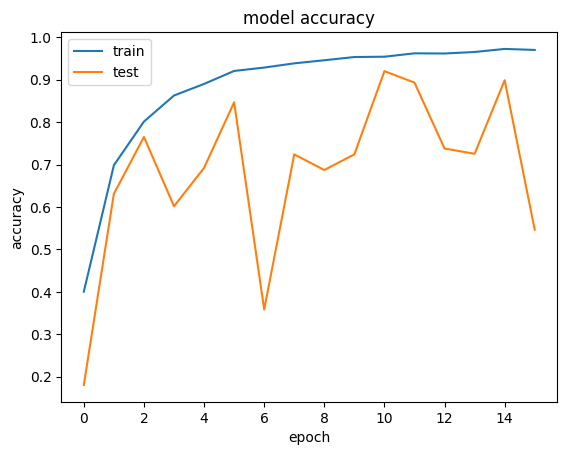

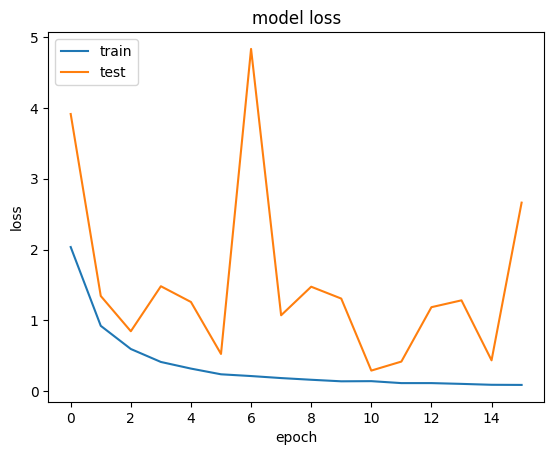

In [ ]:
plt.plot(history_128.history['accuracy'])
plt.plot(history_128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_128.history['loss'])
plt.plot(history_128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Does Augmentation / Class Weights help the model

In [ ]:
# Re-Calculate the class weights for non-augmented dataset
class_weights_nonaug = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y = y_train)
class_weight_dict_nonaug = dict(enumerate(class_weights_nonaug))

Epoch 1/30
283/283 [==============================] - 8s 25ms/step - loss: 2.0455 - accuracy: 0.3867 - val_loss: 1.8811 - val_accuracy: 0.4307
Epoch 2/30
283/283 [==============================] - 7s 24ms/step - loss: 1.0335 - accuracy: 0.6732 - val_loss: 2.0317 - val_accuracy: 0.5400
Epoch 3/30
283/283 [==============================] - 7s 23ms/step - loss: 0.7241 - accuracy: 0.7658 - val_loss: 2.4251 - val_accuracy: 0.4287
Epoch 4/30
283/283 [==============================] - 7s 23ms/step - loss: 0.5082 - accuracy: 0.8319 - val_loss: 1.1980 - val_accuracy: 0.6817
Epoch 5/30
283/283 [==============================] - 7s 24ms/step - loss: 0.3867 - accuracy: 0.8728 - val_loss: 1.2403 - val_accuracy: 0.6890
Epoch 6/30
283/283 [==============================] - 7s 25ms/step - loss: 0.3056 - accuracy: 0.8975 - val_loss: 1.0802 - val_accuracy: 0.7240
Epoch 7/30
283/283 [==============================] - 7s 25ms/step - loss: 0.2546 - accuracy: 0.9153 - val_loss: 0.7061 - val_accuracy: 0.7840

<BarContainer object of 4 artists>

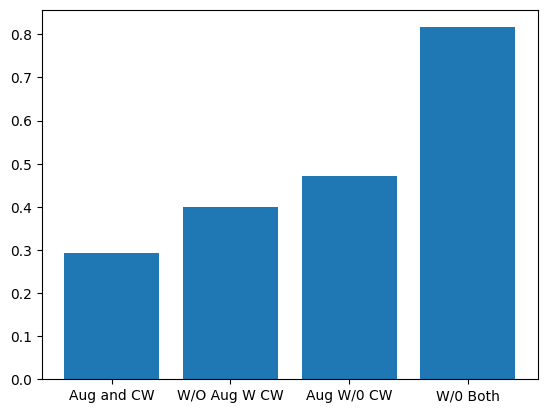

In [ ]:
# Without Augmentation but with Class_Weights
model_128 = base_model_128()
history_128_non_aug = model_128.fit(
    train_non_aug_ds_128,
    validation_data=val_ds_128,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict_nonaug,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        ),
    ]
)


# With Augmentation but without Class_Weights
model_128 = base_model_128()
history_128_wocw = model_128.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=30,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        ),
    ]
)

# Without Both
model_128 = base_model_128()
history_128_nothing = model_128.fit(
    train_non_aug_ds_128,
    validation_data=val_ds_128,
    epochs=30,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        ),
    ]
)

results = [{
    "Aug and CW": min(history_128.history['val_loss']),
    "W/O Aug W CW": min(history_128_non_aug.history['val_loss']),
    "Aug W/0 CW": min(history_128_wocw.history['val_loss']),
    "W/0 Both": min(history_128_nothing.history['val_loss'])
}]

results_aug_df = pd.DataFrame(results)
plt.bar(results_aug_df.columns, results_aug_df.iloc[0])

### Effects of Batch Normalization

In [ ]:
def conv2d_block_wobo(layer_number):
    layer_number = 5 + layer_number
    conv_filter1 = 2**layer_number
    ks = (7,7) if layer_number == 0 else (5,5) if layer_number == 1 else (3,3)    
    return Sequential(
        [
            Conv2D(conv_filter1, ks, padding="same", activation="relu"),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.2)
        ]
    )

Epoch 1/30
368/368 [==============================] - 8s 19ms/step - loss: 4.4793 - accuracy: 0.0736 - val_loss: 2.6938 - val_accuracy: 0.0927
Epoch 2/30
368/368 [==============================] - 7s 18ms/step - loss: 2.6212 - accuracy: 0.1215 - val_loss: 2.5783 - val_accuracy: 0.1507
Epoch 3/30
368/368 [==============================] - 7s 18ms/step - loss: 2.2238 - accuracy: 0.2623 - val_loss: 2.1484 - val_accuracy: 0.3620
Epoch 4/30
368/368 [==============================] - 7s 18ms/step - loss: 1.8832 - accuracy: 0.3848 - val_loss: 2.3203 - val_accuracy: 0.2253
Epoch 5/30
368/368 [==============================] - 7s 18ms/step - loss: 1.5807 - accuracy: 0.4839 - val_loss: 1.6035 - val_accuracy: 0.4753
Epoch 6/30
368/368 [==============================] - 7s 18ms/step - loss: 1.3239 - accuracy: 0.5672 - val_loss: 1.2841 - val_accuracy: 0.6180
Epoch 7/30
368/368 [==============================] - 7s 18ms/step - loss: 1.0778 - accuracy: 0.6474 - val_loss: 0.9426 - val_accuracy: 0.7403

Model With Batch Normalization  Model Without Batch Normalization
0                        0.292167                           0.284403

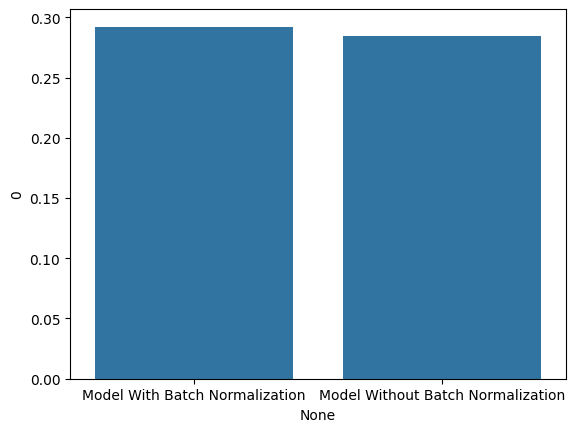

In [ ]:
def show_effect_batch_norm():
    model = Sequential()

    for i in range(4):
        model.add(conv2d_block_wobo(i))
        if ((i+1) % 2 == 0):
            model.add(MaxPooling2D(2, 2))
            model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(15, activation="softmax"))

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


model_128_wobo = show_effect_batch_norm()
history_128_wobo = model_128_wobo.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        )
    ]
)

results_bo = [{
    "Model With Batch Normalization": min(history_128.history['val_loss']),
    "Model Without Batch Normalization": min(history_128_wobo.history['val_loss'])
}]

results_batchnormalization= pd.DataFrame(results_bo)
sns.barplot(x= results_batchnormalization.columns,y= results_batchnormalization.iloc[0])
results_batchnormalization

## Hyperparameter Tuning 
- Number of Layers
- Batchsize, Dropout, Dense

### Tuning Number of Layers

In [ ]:
def tune_filters(number_of_layers):
    model = Sequential()

    for i in range(number_of_layers):
        model.add(conv2d_block(i))
        if ((i+1) % 2 == 0):
            model.add(MaxPooling2D(2, 2))
            model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))  # hidden layer
    model.add(Dense(15, activation="softmax"))  # output layer

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    history = model.fit(
        train_ds_128,
        validation_data=val_ds_128,
        epochs=30,
        batch_size=128,
        shuffle=True,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                verbose=1,
                mode="min",
                restore_best_weights=True,
            )
        ],
    )
    scores = model.evaluate(test_ds_128)
    testError = 100 - scores[1] * 100
    return history, scores[1], testError

In [ ]:
results = [] 
for i in range(1,6,1):
    history_filters, accuracy, testError = tune_filters(i)
    results.append(
        {   
            "number_of_layers": i,
            "accuracy": accuracy,
            "testError": testError,
            "Val_Accuracy": max(history_filters.history['val_accuracy']),
            "Val_Loss": min(history_filters.history['val_loss'])
        }
    )
results_layers_df = pd.DataFrame(results)
results_layers_df

Epoch 1/30


368/368 [==============================] - 8s 20ms/step - loss: 4.4344 - accuracy: 0.2995 - val_loss: 2.0936 - val_accuracy: 0.4063
Epoch 2/30
368/368 [==============================] - 7s 19ms/step - loss: 1.6066 - accuracy: 0.4990 - val_loss: 1.8376 - val_accuracy: 0.4923
Epoch 3/30
368/368 [==============================] - 7s 19ms/step - loss: 1.2811 - accuracy: 0.5803 - val_loss: 1.6094 - val_accuracy: 0.5237
Epoch 4/30
368/368 [==============================] - 7s 19ms/step - loss: 1.0866 - accuracy: 0.6394 - val_loss: 2.1654 - val_accuracy: 0.5347
Epoch 5/30
368/368 [==============================] - 7s 19ms/step - loss: 0.9065 - accuracy: 0.6916 - val_loss: 2.5836 - val_accuracy: 0.4193
Epoch 6/30
368/368 [==============================] - 7s 19ms/step - loss: 0.8056 - accuracy: 0.7312 - val_loss: 3.4048 - val_accuracy: 0.5177
Epoch 7/30
368/368 [==============================] - 7s 19ms/step - loss: 0.6884 - accuracy: 0.7663 - val_loss: 1.7452 - val_accuracy: 0.5970
Epoch 8/30

number_of_layers  accuracy  testError  Val_Accuracy  Val_Loss
0                 1  0.512667  48.733336      0.597000  1.609367
1                 2  0.668333  33.166665      0.750667  1.712590
2                 3  0.852333  14.766669      0.846667  0.599754
3                 4  0.931333   6.866664      0.924333  0.289937
4                 5  0.866667  13.333333      0.876667  0.614633

<Axes: xlabel='number_of_layers', ylabel='accuracy'>

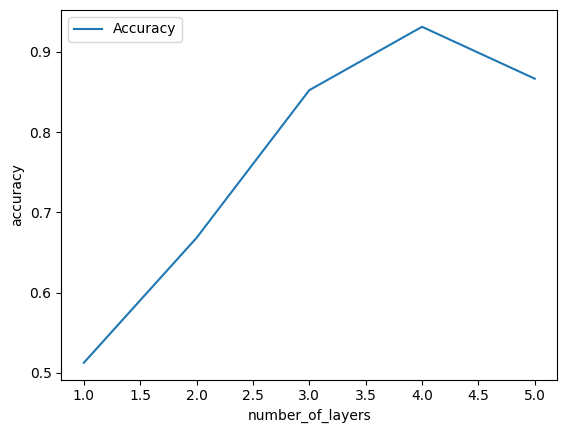

In [ ]:
sns.lineplot(x=results_layers_df['number_of_layers'], y=results_layers_df['accuracy'], label="Accuracy")

### Tuning Batchsize, Dropout, Dense

In [22]:
def tuning_model_bsdd_128(batchsize, dropout, dense):
    model = Sequential()

    for i in range(4):
        model.add(conv2d_block(i))
        if ((i+1) % 2 == 0):
            model.add(MaxPooling2D(2, 2))
            model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense, activation="relu"))  # hidden layer
    model.add(Dense(15, activation="softmax"))  # output layer

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    history = model.fit(
        train_ds_128,
        validation_data=val_ds_128,
        epochs=50,
        batch_size=batchsize,
        shuffle=True,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                verbose=1,
                mode="min",
                restore_best_weights=True,
            )
        ],
    )

    scores = model.evaluate(test_ds_128)
    testError = 100 - scores[1] * 100
    return history, scores[1], testError, scores[0], model 

In [23]:
def grid_search(batch_sizes, dropouts, dense_sizes):
    # Store the results
    results = []
    best_loss = float('inf')
    best_model = None

    # Iterate over all combinations of hyperparameters
    for batch_size in batch_sizes:
        for dropout in dropouts:
            for dense_size in dense_sizes:
                history, accuracy, test_error, test_loss, current_model = tuning_model_bsdd_128(batch_size, dropout, dense_size)
                results.append({
                    'batch_size': batch_size,
                    'dropout': dropout,
                    'dense_size': dense_size,
                    'accuracy': accuracy,
                    'test_error': test_error,
                    'test_loss': test_loss
                })
                current_loss = min(history.history['val_loss'])
                print(f"Current loss: {current_loss}")
                if current_loss < best_loss:
                    best_loss = current_loss
                    best_model = current_model
                    best_model.save_weights('model_128_final.h5')
                    print(f"New best loss: {best_loss}")
    return results

# Define the hyperparameters to test
batch_sizes = [32, 64, 128]
dropouts = [0.2, 0.3, 0.5]
dense_sizes = [64,128,256,512]
# Run the grid search
results = grid_search(batch_sizes, dropouts, dense_sizes)
results_bsdd = pd.DataFrame(results)
results_bsdd

Epoch 1/50
368/368 [==============================] - 19s 27ms/step - loss: 2.0711 - accuracy: 0.3586 - val_loss: 1.7001 - val_accuracy: 0.4553
Epoch 2/50
368/368 [==============================] - 8s 22ms/step - loss: 1.0196 - accuracy: 0.6820 - val_loss: 1.1569 - val_accuracy: 0.6540
Epoch 3/50
368/368 [==============================] - 8s 22ms/step - loss: 0.6614 - accuracy: 0.7825 - val_loss: 1.2416 - val_accuracy: 0.6507
Epoch 4/50
368/368 [==============================] - 8s 22ms/step - loss: 0.4712 - accuracy: 0.8500 - val_loss: 1.7491 - val_accuracy: 0.5543
Epoch 5/50
368/368 [==============================] - 8s 22ms/step - loss: 0.3711 - accuracy: 0.8788 - val_loss: 0.5917 - val_accuracy: 0.8290
Epoch 6/50
368/368 [==============================] - 8s 22ms/step - loss: 0.2990 - accuracy: 0.9038 - val_loss: 2.9994 - val_accuracy: 0.4900
Epoch 7/50
368/368 [==============================] - 8s 22ms/step - loss: 0.2475 - accuracy: 0.9203 - val_loss: 3.5874 - val_accuracy: 0.535

batch_size  dropout  dense_size  accuracy  test_error  test_loss
0           32      0.2          64  0.928667    7.133335   0.243972
1           32      0.2         128  0.926333    7.366669   0.254850
2           32      0.2         256  0.805000   19.499999   0.799193
3           32      0.2         512  0.871667   12.833333   0.505309
4           32      0.3          64  0.927667    7.233334   0.288431
5           32      0.3         128  0.933000    6.699997   0.234405
6           32      0.3         256  0.918000    8.200002   0.361491
7           32      0.3         512  0.909000    9.100002   0.380410
8           32      0.5          64  0.903667    9.633332   0.321595
9           32      0.5         128  0.853667   14.633334   0.480728
10          32      0.5         256  0.862333   13.766664   0.478681
11          32      0.5         512  0.819333   18.066669   0.676399
12          64      0.2          64  0.934667    6.533331   0.237674
13          64      0.2         128  0.913000    8.700001   0.331931
14          64      0.2         256  0.867667   13.233334   0.451538
15          64      0.2         512  0.924000    7.599998   0.354365
16          64      0.3          64  0.923000    7.700002   0.257179
17          64      0.3         128  0.927667    7.233334   0.258897
18          64      0.3         256  0.896333   10.366666   0.420052
19          64      0.3         512  0.887333   11.266667   0.396597
20          64      0.5          64  0.897000   10.299999   0.439954
21          64      0.5         128  0.796000   20.400000   0.662019
22          64      0.5         256  0.894667   10.533333   0.445318
23          64      0.5         512  0.918333    8.166665   0.399047
24         128      0.2          64  0.843333   15.666670   0.561732
25         128      0.2         128  0.921000    7.900000   0.311774
26         128      0.2         256  0.915333    8.466667   0.380248
27         128      0.2         512  0.892333   10.766667   0.590702
28         128      0.3          64  0.915667    8.433336   0.273639
29         128      0.3         128  0.902333    9.766668   0.323833
30         128      0.3         256  0.853000   14.700001   0.597403
31         128      0.3         512  0.914667    8.533335   0.360889
32         128      0.5          64  0.903333    9.666669   0.345033
33         128      0.5         128  0.925333    7.466668   0.312059
34         128      0.5         256  0.878667   12.133336   0.501231
35         128      0.5         512  0.919667    8.033335   0.409161

In [31]:
results_bsdd.sort_values(by=['test_loss'], ascending=True)

batch_size  dropout  dense_size  accuracy  test_error  test_loss
5           32      0.3         128  0.933000    6.699997   0.234405
12          64      0.2          64  0.934667    6.533331   0.237674
0           32      0.2          64  0.928667    7.133335   0.243972
1           32      0.2         128  0.926333    7.366669   0.254850
16          64      0.3          64  0.923000    7.700002   0.257179
17          64      0.3         128  0.927667    7.233334   0.258897
28         128      0.3          64  0.915667    8.433336   0.273639
4           32      0.3          64  0.927667    7.233334   0.288431
25         128      0.2         128  0.921000    7.900000   0.311774
33         128      0.5         128  0.925333    7.466668   0.312059
8           32      0.5          64  0.903667    9.633332   0.321595
29         128      0.3         128  0.902333    9.766668   0.323833
13          64      0.2         128  0.913000    8.700001   0.331931
32         128      0.5          64  0.903333    9.666669   0.345033
15          64      0.2         512  0.924000    7.599998   0.354365
31         128      0.3         512  0.914667    8.533335   0.360889
6           32      0.3         256  0.918000    8.200002   0.361491
26         128      0.2         256  0.915333    8.466667   0.380248
7           32      0.3         512  0.909000    9.100002   0.380410
19          64      0.3         512  0.887333   11.266667   0.396597
23          64      0.5         512  0.918333    8.166665   0.399047
35         128      0.5         512  0.919667    8.033335   0.409161
18          64      0.3         256  0.896333   10.366666   0.420052
20          64      0.5          64  0.897000   10.299999   0.439954
22          64      0.5         256  0.894667   10.533333   0.445318
14          64      0.2         256  0.867667   13.233334   0.451538
10          32      0.5         256  0.862333   13.766664   0.478681
9           32      0.5         128  0.853667   14.633334   0.480728
34         128      0.5         256  0.878667   12.133336   0.501231
3           32      0.2         512  0.871667   12.833333   0.505309
24         128      0.2          64  0.843333   15.666670   0.561732
27         128      0.2         512  0.892333   10.766667   0.590702
30         128      0.3         256  0.853000   14.700001   0.597403
21          64      0.5         128  0.796000   20.400000   0.662019
11          32      0.5         512  0.819333   18.066669   0.676399
2           32      0.2         256  0.805000   19.499999   0.799193

### Final Model and load in weights

In [32]:
def conv2d_block(layer_number):
    layer_number = 5 + layer_number
    conv_filter1 = 2**layer_number
    ks = (7,7) if layer_number == 0 else (5,5) if layer_number == 1 else (3,3)    
    return Sequential(
        [
            Conv2D(conv_filter1, ks, padding="same", activation="relu"),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.2)
        ]
    )

In [33]:
def finalmodel():
    model = Sequential()

    for i in range(4):
        model.add(conv2d_block(i))
        if ((i+1) % 2 == 0):
            model.add(MaxPooling2D(2, 2))
            model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation="relu"))  # hidden layer
    model.add(Dense(15, activation="softmax"))  # output layer

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [34]:
model_128 = finalmodel()
model_128.build((32, 128, 128, 1))
model_128.load_weights('model_128_final.h5')
model_128.evaluate(test_ds_128)

94/94 [==============================] - 2s 12ms/step - loss: 0.2344 - accuracy: 0.9330


[0.23440499603748322, 0.9330000281333923]

## Load in model from .h5 file